# Serial FL Simulation
In this notebook, we are going to show how to simulate an FL experiment on a single machine by having each client running serially. It should be noted that only simulating synchronous FL algorithms makes sense when the experiments running serially. We use 10 clients running serially in this example.

In [1]:
num_clients = 10

## Load server configurations
In the example, we are going to use the `FedAvg` server aggregation algorithm and the MNIST dataset by loading the server configurations from `examples/resources/configs/mnist/server_fedavg.yaml`.

In [2]:
from omegaconf import OmegaConf
server_config_file = "../../examples/resources/configs/mnist/server_fedavg.yaml"
server_config = OmegaConf.load(server_config_file)
print(OmegaConf.to_yaml(server_config))

client_configs:
  train_configs:
    trainer: NaiveTrainer
    mode: step
    num_local_steps: 100
    optim: Adam
    optim_args:
      lr: 0.001
    loss_fn_path: ./resources/loss/celoss.py
    loss_fn_name: CELoss
    do_validation: true
    do_pre_validation: true
    metric_path: ./resources/metric/acc.py
    metric_name: accuracy
    use_dp: false
    epsilon: 1
    clip_grad: false
    clip_value: 1
    clip_norm: 1
    train_batch_size: 64
    val_batch_size: 64
    train_data_shuffle: true
    val_data_shuffle: false
  model_configs:
    model_path: ./resources/model/cnn.py
    model_name: CNN
    model_kwargs:
      num_channel: 1
      num_classes: 10
      num_pixel: 28
  comm_configs:
    compressor_configs:
      enable_compression: true
      lossy_compressor: SZ2Compressor
      lossless_compressor: blosc
      error_bounding_mode: REL
      error_bound: 0.001
      param_cutoff: 1024
server_configs:
  scheduler: SyncScheduler
  scheduler_kwargs:
    num_clients: 2
    

💡 It should be noted that configuration fields such as `loss_fn_path`, `metric_path`, and `model_path` are the paths to the corresponding files, so we need to change their relative paths now to make sure the paths point to the right files. 

💡 We also change the `num_global_epochs` from 10 to 5.

⚠️ We also need change `num_clients` in `server_configs.scheduler_kwargs` to 10.

In [3]:
server_config.client_configs.train_configs.loss_fn_path = '../../examples/resources/loss/celoss.py'
server_config.client_configs.train_configs.metric_path = '../../examples/resources/metric/acc.py'
server_config.client_configs.model_configs.model_path = '../../examples/resources/model/cnn.py'
server_config.server_configs.num_global_epochs = 5
server_config.server_configs.scheduler_kwargs.num_clients = num_clients

## Load client configurations
In this example, we suppose that `num_clients=10` and load the basic configurations for all the clients from `examples/configs/mnist/client_1.yaml`. Let's first take a look at this basic configuration.

In [4]:
client_config_file = "../../examples/resources/configs/mnist/client_1.yaml"
client_config = OmegaConf.load(client_config_file)
print(OmegaConf.to_yaml(client_config))

train_configs:
  device: cpu
  logging_id: Client1
  logging_output_dirname: ./output
  logging_output_filename: result
data_configs:
  dataset_path: ./resources/dataset/mnist_dataset.py
  dataset_name: get_mnist
  dataset_kwargs:
    num_clients: 2
    client_id: 0
    partition_strategy: class_noniid
    visualization: true
    output_dirname: ./output
    output_filename: visualization.pdf
comm_configs:
  grpc_configs:
    server_uri: localhost:50051
    max_message_size: 1048576
    use_ssl: false



For the configuration above, it should be mentioned that `data_configs` contains the necessary configurations to load the simulated "local" datasets for each client. Specifically,

- `dataset_path` is the path to the file that contains the function to load the dataset
- `dataset_name` is the function nation that loads the dataset in the above file
- `dataset_kwargs` are the keyword arguments for that function

In the `get_mnist` function above, it partitions the MNIST dataset into `num_clients` client splits in an IID/non-IID (IID: independent identically distributed) manner. 

Now we need to modify the general client configurations for different clients. Specifically, we make the following changes:

- Change `logging_id` for each client
- Change the relative path of `dataset_path` to make it point to the right file
- Change `num_clients` to 10 and `client_id` to [0, 1, .., 9] for different clients.
- Change `visualization` to False for nine clients to only have one data distribution visualization plots.

In [5]:
import copy
client_configs = [
    copy.deepcopy(client_config) for _ in range(num_clients)
]
for i in range(num_clients):
    client_configs[i].train_configs.logging_id = f'Client_{i+1}'
    client_configs[i].data_configs.dataset_path = '../../examples/resources/dataset/mnist_dataset.py'
    client_configs[i].data_configs.dataset_kwargs.num_clients = num_clients
    client_configs[i].data_configs.dataset_kwargs.client_id = i
    client_configs[i].data_configs.dataset_kwargs.visualization = True if i == 0 else False

## Create FL server agent and client agents
In APPFL, we use agent to act on behalf of the FL server and FL clients to do necessary steps for the federated learning experiments. User can easily create the agents using the server/client configurations we loaded (and modified a little bit) from the configuration yaml file. Creating the client agents will load the loacal dataset and plot the data distribution visualization as shown below.

[Zilinghans-MBP.attlocal.net:97585] shmem: mmap: an error occurred while determining whether or not /var/folders/b_/gwq73k4j7z53_f2qmdwcl22w0000gp/T//ompi.Zilinghans-MBP.502/jf.0/1240334336/sm_segment.Zilinghans-MBP.502.49ee0000.0 could be created.
[2024-08-24 23:08:01,733 INFO server]: Logging to ./output/result_Server_2024-08-24-23:08:01.txt
[2024-08-24 23:08:01,733 INFO server]: Setting seed value to 42
[2024-08-24 23:08:01,739 INFO Client_1]: Logging to ./output/result_Client_1_2024-08-24-23:08:01.txt
[2024-08-24 23:08:09,062 INFO Client_2]: Logging to ./output/result_Client_2_2024-08-24-23:08:09.txt
[2024-08-24 23:08:15,508 INFO Client_3]: Logging to ./output/result_Client_3_2024-08-24-23:08:15.txt
[2024-08-24 23:08:22,046 INFO Client_4]: Logging to ./output/result_Client_4_2024-08-24-23:08:22.txt
[2024-08-24 23:08:28,670 INFO Client_5]: Logging to ./output/result_Client_5_2024-08-24-23:08:28.txt
[2024-08-24 23:08:35,214 INFO Client_6]: Logging to ./output/result_Client_6_2024-08-

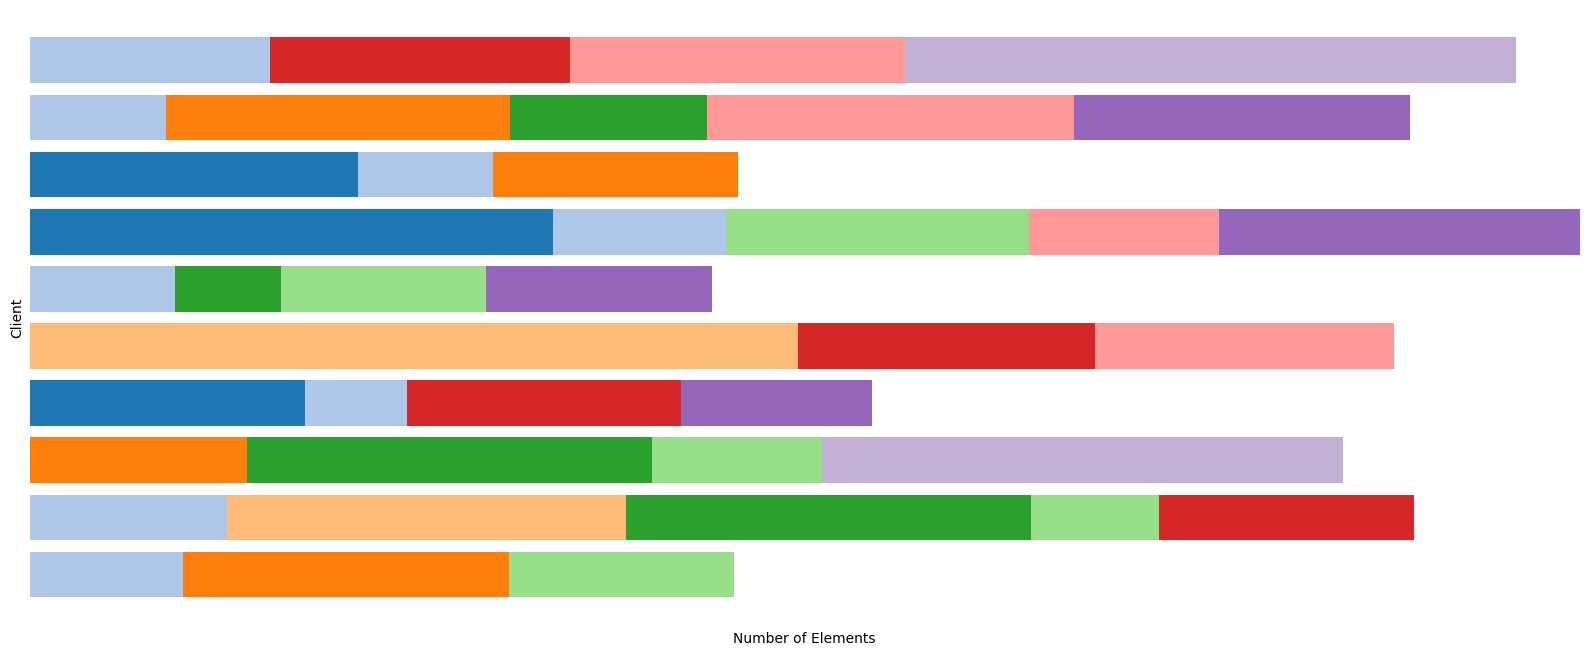

In [6]:
from appfl.agent import ServerAgent, ClientAgent
server_agent = ServerAgent(server_agent_config=server_config)
client_agents =[
    ClientAgent(client_agent_config=client_configs[i]) for i in range(num_clients)
]

## Start the training process

The server configuration files contains many client configurations which should apply for ALL clients. Now, we need to get those configurations from the server and provide them to the client agents.

In [7]:
# Get additional client configurations from the server
client_config_from_server = server_agent.get_client_configs()
for client_agent in client_agents:
    client_agent.load_config(client_config_from_server)

Then, let the clients load initial global model from the server and optionally send the number of local data to the server for weighted aggregation.

💡 **Note**: Typically, `server_agent.get_parameters()` blocks the result return or returns a `Future` object, and only returns the global model after receiving `num_clients` calls to synchronoize to process for clients to get the initial model, ensuring all the clients have the same initial model weights. However, as we are doing serial simulation, we don't want the blocking, so we pass `serail_run=True` when calling the function to get the global model immediately.

In [8]:
# Load initial global model from the server
init_global_model = server_agent.get_parameters(serial_run=True)
for client_agent in client_agents:
    client_agent.load_parameters(init_global_model)

# [Optional] Set number of local data to the server
for i in range(num_clients):
    sample_size = client_agents[i].get_sample_size()
    server_agent.set_sample_size(
        client_id=client_agents[i].get_id(), 
        sample_size=sample_size
    )

Now, we can start the training iterations. Please note the following points:

- `server_agent.training_finished` will return a boolean flag indicating whether the training has reached the specified `num_global epochs`
- `client_agent.train` trains the client local model using the client's "local" data
- `server_agent.global_update` takes one client's local model together with a client id (can be get by `client_agent.get_id`) to schedule the global update for the client local model. For synchronous server aggregation algorithms such as `FedAvg`, they will not update the global model until receiving local models from all `num_clients=10` clients, so the call to `global_update` will return a `concurrent.futures.Future` object (if you set `blocking=False`, otherwise, it will block forever for serial simulation), which will be set after all client local models are sent for global update. 
- In the output log, `Pre Val?` means whether it is validation prior to the local training. As each client only holds data from 3 to 5 classes, the validation accuracy even drops after local training. However, the global model accuracy continues to increase, showcasing the capabilities of federated learning in improving the generalizability of the trained machine learning model.

In [9]:
while not server_agent.training_finished():
    new_global_models = []
    for client_agent in client_agents:
        # Client local training
        client_agent.train()
        local_model = client_agent.get_parameters()
        # "Send" local model to server and get a Future object for the new global model
        # The Future object will be resolved when the server receives local models from all clients
        new_global_model_future = server_agent.global_update(
            client_id=client_agent.get_id(), 
            local_model=local_model,
            blocking=False,
        )
        new_global_models.append(new_global_model_future)
    # Load the new global model from the server
    for client_agent, new_global_model_future in zip(client_agents, new_global_models):
        client_agent.load_parameters(new_global_model_future.result())

[2024-08-24 23:09:12,106 INFO Client_1]:      Round   Pre Val?       Time Train Loss Train Accuracy   Val Loss Val Accuracy
[2024-08-24 23:09:13,136 INFO Client_1]:          0          Y                                          2.3006      15.9300
[2024-08-24 23:09:15,946 INFO Client_1]:          0          N     2.8091     0.4323        90.8109    15.4995      30.3500
[2024-08-24 23:09:16,000 INFO Client_2]:      Round   Pre Val?       Time Train Loss Train Accuracy   Val Loss Val Accuracy
[2024-08-24 23:09:17,026 INFO Client_2]:          0          Y                                          2.3006      15.9300
[2024-08-24 23:09:20,207 INFO Client_2]:          0          N     3.1809     0.3130        87.7656     9.9495      48.6000
[2024-08-24 23:09:20,264 INFO Client_3]:      Round   Pre Val?       Time Train Loss Train Accuracy   Val Loss Val Accuracy
[2024-08-24 23:09:21,306 INFO Client_3]:          0          Y                                          2.3006      15.9300
[2024-08